In [ ]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora       
from nltk.stem import WordNetLemmatizer as lemmatize

from gensim.utils import  simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

In [ ]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
stop_words.extend(['app', 'barclays','need','will','pay'])
%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import pandas as pd
import numpy as np
import json, os, uuid
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/BarclaysReviews/data/final_merged_reviews.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ratingColName = 'customer_sentiment'
df[ratingColName] = 'POSITIVE'
for i in df.index:
    if df['rating'][i] > 3:
      df[ratingColName][i] = 'POSITIVE'
    else:
      df[ratingColName][i] = 'NEGATIVE'
#df = df[df['review_description'].notnull() & df[ratingColName].str.contains('NEGATIVE')]

<ipython-input-7-7c1a3ace555d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ratingColName][i] = 'NEGATIVE'
<ipython-input-7-7c1a3ace555d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ratingColName][i] = 'POSITIVE'


In [ ]:
df = df[df['review_description'].notnull()]
replace_dict = {"google pay":"googlepay","contactless card":"contactlesscrd","credit card":"credicard","debit card":"debitcard"}
df['review_description'] = df['review_description'].str.lower()
df['review_description'].replace(replace_dict,inplace=True,regex=True)
df['review_description'] = df['review_description'].str.lower()
df[df["review_description"].str.contains("google")][["review_description", "rating",ratingColName]] 

<ipython-input-10-118d93d1b5c1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_description'] = df['review_description'].str.lower()
<ipython-input-10-118d93d1b5c1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_description'].replace(replace_dict,inplace=True,regex=True)
<ipython-input-10-118d93d1b5c1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

,review_description,rating,customer_sentiment
44,"glad you've added googlepay recently, that is ...",4,POSITIVE
159,used to work very well but is now useless. i c...,1,NEGATIVE
174,"this is a really nice app and bank. now, they ...",5,POSITIVE
200,just spoke to a barclays customer service rep....,1,NEGATIVE
201,"finally, we can now use googlepay for debitcar...",4,POSITIVE
...,...,...,...
30107,"please fix contactless. i've called, told it w...",5,POSITIVE
30293,won't allow me to use googlepay. it seems that...,3,NEGATIVE
30434,frustrating. no googlepay or samsung pay suppo...,1,NEGATIVE
30967,there is only the option to register for the a...,5,POSITIVE


In [ ]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.review_description.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['now', 'this', 'is', 'awful', 'because', 'cant', 'make', 'payments', 'with', 'my', 'phone', 'but', 'then', 'every', 'time', 'open', 'the', 'app', 'get', 'prompted', 'to', 'change', 'settings', 'so', 'that', 'can', 'make', 'payments', 'with', 'my', 'phone', 'and', 'after', 'ive', 'done', 'that', 'it', 'tells', 'me', 'that', 'cant', 'make', 'payments', 'with', 'my', 'phone', 'every', 'time', 'after', 'that', 'when', 'just', 'want', 'to', 'use', 'the', 'app', 'it', 'holds', 'everything', 'up', 'with', 'prompt', 'that', 'cant', 'make', 'payments', 'with', 'my', 'phone']]


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy 
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nlp.Defaults.stop_words.update(['app', 'barclays','need','will'])
nlp.Defaults.stop_words.update(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
len(nlp.Defaults.stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


348

In [ ]:

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
import nltk
nltk.download('punkt')
import re
wnl = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Build the bigram and trigram models

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in nlp.Defaults.stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    #nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    i =0
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        #print(doc)
        #texts_out.append([token.lemma_ for token in doc ])
         #[wnl.lemmatize(token.lemma_.lower()) for token in nlp(text) if not token.is_stop and not token.is_punct]
        regex_num_ponctuation = '(\d+)|([^\w\s])'
        regex_little_words = r'(\b\w{1,2}\b)'
        texts_out_temp = [token.lemma_ for token in doc if  not token.is_punct ]
        texts_out.append([wnl.lemmatize(t) for t in word_tokenize(' '.join(texts_out_temp)) 
              if not re.search(regex_num_ponctuation, t) and not re.search(regex_little_words, t)  ])
        print(texts_out[i])
        i = i+1
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in nlp.Defaults.stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

Streaming output truncated to the last 5000 lines.
['fast', 'safe', 'reliable']
['efficient', 'secure']
['excellent', 'xxx']
[]
[]
['quick', 'simple']
['insurmountable', 'issue', 'far', 'difficulty', 'pay', 'cheque', 'android', 'fail', 'successful', 'ipad']
['work', 'account', 'credicard', 'statement', 'available', 'single', 'transaction', 'display', 'payment', 'amount', 'customer', 'service', 'call', 'multiple', 'time', 'absentia', 'help', 'fix', 'month', 'open', 'account', 'worth', 'will', 'not', 'able', 'actually', 'online', 'banking', 'support']
['good', 'bank', 'good', 'bank']
['eye', 'account', 'minimum', 'time']
['excellent', 'service', 'keep', 'control', 'account']
['totally', 'useless', 'pay', 'cheque', 'cheque', 'flat', 'light', 'photo', 'cheque', 'come', 'weird', 'angle', 'see', 'like', 'not', 'understand', 'eventually', 'take', 'decent', 'photo', 'tell', 'picture', 'not', 'spend', 'half', 'hour', 'take', 'retake', 'photo', 'acceptable', 'useful', 'not', 'bank', 'middle', 'p

In [ ]:
len(data_ready)
df['cleaned_data']=data_ready
df['cleaned_data']=df['cleaned_data'].apply(lambda x: ' '.join(x))
def saveFileToDrive(path,dataframe):

  with open(path, 'w', encoding = 'utf-8-sig') as f:
    dataframe.to_csv(f)
    print("Saving file : "+path)
saveFileToDrive("/content/drive/MyDrive/BarclaysReviews/data/final_merged_reviews_cleaned.csv",df)

Saving file : /content/drive/MyDrive/BarclaysReviews/data/final_merged_reviews_cleaned.csv


In [ ]:
pd.set_option('display.max_colwidth', -1)
df[df['customer_sentiment'].str.contains('NEGATIVE')][['review_description', 'cleaned_data','rating']].head(20)

<ipython-input-36-47698783d821>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,review_description,cleaned_data,rating
0,"now this is awful because a) i can't make payments with my phone, but then b) every time i open the app i get prompted to change settings so that i can make payments with my phone, and after i've done that it tells me that i can't make payments with my phone. every time after that when i just want to use the app it holds everything up with a prompt that i can't make payments with my phone!",awful payment phone time open prompt change setting payment phone tell payment phone time hold prompt payment phone,1
1,"crashes all the time and don't get notifications anymore and contactless payment doesn't work anymore,been over 2 months now.rubbish app update when is this likely to be sorted out i don't even get notified when money go's in or out now",crash time notification anymore contactless payment work anymore month rubbish update likely sort notify money,1
5,bad experience - error messages despite being up most recent version. not showing my mortgage on the app. limiting my option as to which account to open. not stable at all,bad experience error_message despite recent version mortgage limiting option account open stable,1
8,"have to echo most of what andrea has said just below as this has been my experience as well. when it works, it works very well and quickly but there are so many moments when it just lets you down. random crashes when idle in a screen, infinite loading, then exactly the same again, had to restart phone to even open the app - i also was left embarrassed at a till because i didn't bring my card with me and i was just getting a black screen. there really should never be downtime for a banking app.",echo andrea experience work work quickly moment let random crash idle screen infinite loading exactly restart phone open leave embarrassed till bring card black screen downtime banking,3
9,"although the app is good for sorting finances i've always had an issue with contactless, i have to rlepgon every 2-3 days and refresh the settings, now however it won't let me change the settings to allow contactless all together. i get to the screen and try to click ok to authorise it using contactless and nothing happens, it's very frustrating!",sort finance issue contactless rlepgon day refresh setting let change setting allow contactless screen click authorise contactless happen frustrating,2
13,"my list of usual payees to transfere has gone and left with only 2 on my usual list. this was on saturday i had to re add another payee to my list which is already saved but couldn't find them. updated .24,4,23, update all my payees have disappeared on my app, can some one help me please",list usual payee transfere leave usual list saturday add payee list save find update update payee disappear help,3
14,constant bugs currently. app crashes and often needs phone restart to fix. the app was fine for years until a recent update,constant bug currently crash phone restart fix fine year recent update,1
18,cannot input mobile phone number from thailand,input mobile phone number thailand,1
20,"the app does not always show the (deposit) or and (withdrawal) - [notifications], even though on the app it shows the (deposit) and or (withdrawal) transactions on the statement.",deposit withdrawal notification deposit withdrawal transaction statement,1
21,"update april 2023 phone forces app into deep sleep as it crashes constantly. contactless payments inconsistent, normally stops working when in a rush or a queue of people behind me. so many issues with it. poor, still only 1 star",update april phone force deep_sleep crash constantly contactless payment inconsistent normally stop work rush queue people issue poor star,1


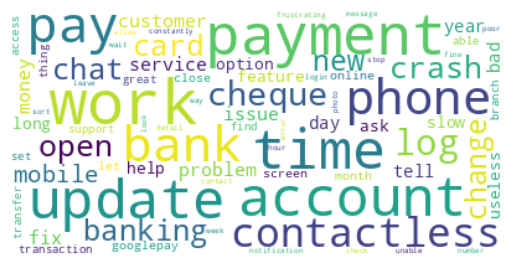

In [ ]:


import matplotlib.pyplot as plt

%matplotlib inline

from wordcloud import WordCloud


text2 = " ".join(title for title in df[df['customer_sentiment'].str.contains('NEGATIVE')].cleaned_data)

# Creating word_cloud with text as argument in .generate() method

word_cloud2 = WordCloud(collocations = False, background_color = 'white',max_font_size=50, max_words=75).generate(text2)

# Display the generated Word Cloud

plt.imshow(word_cloud2, interpolation='bilinear')

plt.axis("off")

plt.show()
